# Fine-Tuned YOLO Model with Normalization




## Main Features

The modeling process focused on the safety of construction workers and the presence of PPE gear. The following classes were used to train the model:

- Hardhat
- Mask
- NO-Hardhat
- NO-Mask
- NO-Safety Vest
- Person
- Safety Cone
- Safety Vest
- Machinery
- Vehicle

## Model Choice

The **YOLOv9** model was selected due to its efficient object detection capabilities.

### Key Features Considered:

- **Convolutional Neural Network (CNN) Backbone**: Utilizes CNN for feature extraction, essential for detecting and classifying objects in images.

- **CSPDarknet Architecture**: The model leverages CSPDarknet, which helps in focusing on the crucial details in the image, optimizing both speed and accuracy in feature extraction.

- **Anchor-Free Detection**: YOLOv9 uses an anchor-free approach, meaning it doesn’t rely on predefined areas (anchors) for object detection. Instead, it dynamically adapts to objects of varying sizes and shapes, enhancing detection accuracy across different object scales.


### Package to install

In [1]:
# !pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 380.0 kB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_6

### Imports

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import os
import re
import glob
import torch
import random
import yaml

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns

import IPython.display as display
from PIL import Image
import cv2

from ultralytics import YOLO
from google.colab import drive

### Pre setup for drive access and configuration for YOLO model

### Fine-Tuning Applied:

- **Epochs**: 70  
  - Represents the total number of training epochs. Each epoch indicates a full pass over the entire dataset.
  
- **Batch Size**: 16  
  - Refers to the number of training examples used in one iteration of the model’s learning process. A batch size of 16 was chosen for better generalization.

- **Learning Rate**: 1e-3  
  - Defines the speed at which the model learns from the data.

- **Learning Rate Factor**: 0.01  
  - Controls the gradual reduction of the learning rate during training, allowing for faster initial learning and finer adjustments later.

- **Weight Decay**: 5e-4  
  - Penalizes large weights to prevent overfitting, ensuring the model generalizes well to new data.

- **Patience**: 20  
  - Specifies the number of epochs to wait without improvement in validation, helping to prevent overfitting by stopping training when further progress stalls.

- **Image Size (Imgsz)**: 640  
  - Maintained consistent image size at 640x640 pixels to ensure uniformity in training.

- **Optimizer**: ‘Auto’  
  - The optimizer adjusts the weights of the model during training to minimize the loss function, with automatic selection based on the model’s configuration.

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

# Define paths in Google Drive
drive_base_path = '/content/drive/MyDrive/Capstone'

# Directory paths
TRAIN_IMAGE_PATH = os.path.join(drive_base_path, 'data', 'images', 'train')
TEST_IMAGE_PATH = os.path.join(drive_base_path, 'data', 'images', 'test')
VALID_IMAGE_PATH = os.path.join(drive_base_path, 'data', 'images', 'valid')

TRAIN_LABEL_PATH = os.path.join(drive_base_path, 'data', 'labels', 'train')
VALID_LABEL_PATH = os.path.join(drive_base_path, 'data', 'labels', 'valid')
TEST_LABEL_PATH = os.path.join(drive_base_path, 'data', 'labels', 'test')

OUTPUT_DIR = os.path.join(drive_base_path, 'model')

class CFG:
    DEBUG = False
    FRACTION = 0.05 if DEBUG else 1.0
    SEED = 88
    CLASSES = ['Hardhat', 'Mask', 'NO-Hardhat', 'NO-Mask',
               'NO-Safety Vest', 'Person', 'Safety Cone',
               'Safety Vest', 'machinery', 'vehicle']
    NUM_CLASSES = len(CLASSES)

    # training
    EPOCHS = 3 if DEBUG else 70
    BATCH_SIZE = 16
    BASE_MODEL = 'yolov9e'
    BASE_MODEL_WEIGHTS = f'{BASE_MODEL}.pt'
    EXP_NAME = f'ppe_css_{EPOCHS}_epochs'

    OPTIMIZER = 'auto'
    LR = 1e-3
    LR_FACTOR = 0.01
    WEIGHT_DECAY = 5e-4
    DROPOUT = 0.0
    PATIENCE = 20
    PROFILE = False
    LABEL_SMOOTHING = 0.0
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

Mounted at /content/drive


### Creating yaml file for YOLO model to access

In [ ]:
def create_yaml_file():
    dict_file = {
        'train': TRAIN_IMAGE_PATH,
        'val': VALID_IMAGE_PATH,
        'test': TEST_IMAGE_PATH,
        'nc': CFG.NUM_CLASSES,
        'names': CFG.CLASSES
    }
    yaml_path = os.path.join(OUTPUT_DIR, 'data.yaml')
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    with open(yaml_path, 'w+') as file:
        yaml.dump(dict_file, file)
    return yaml_path

In [ ]:
### read yaml file created
def read_yaml_file(file_path = OUTPUT_DIR):
    with open(file_path, 'r') as file:
        try:
            data = yaml.safe_load(file)
            return data
        except yaml.YAMLError as e:
            print("Error reading YAML:", e)
            return None

### print it with newlines
def print_yaml_data(data):
    formatted_yaml = yaml.dump(data, default_style=False)
    print(formatted_yaml)

file_path = os.path.join(OUTPUT_DIR, 'data.yaml')
yaml_data = read_yaml_file(file_path)

if yaml_data:
    print_yaml_data(yaml_data)

names:
- Hardhat
- Mask
- NO-Hardhat
- NO-Mask
- NO-Safety Vest
- Person
- Safety Cone
- Safety Vest
- machinery
- vehicle
nc: 10
test: /content/drive/MyDrive/Capstone/data/images/test
train: /content/drive/MyDrive/Capstone/data/images/train
val: /content/drive/MyDrive/Capstone/data/images/valid



### Checking Image Sizes

In [ ]:
mode_paths = {
    'train': TRAIN_IMAGE_PATH,
    'valid': VALID_IMAGE_PATH,
    'test': TEST_IMAGE_PATH,
}

for mode, path in mode_paths.items():
    print(f'\nImage sizes in {mode} set:')

    img_size = 0
    for file in glob.glob(os.path.join(path, '*')):
        image = Image.open(file)

        if image.size != img_size:
            print(f'{image.size}')
            img_size = image.size
            print('\n')


Image sizes in train set:
(640, 640)



Image sizes in valid set:
(640, 640)



Image sizes in test set:
(640, 640)




### Normalisation Process

Streaming output truncated to the last 5000 lines.
Saved normalized image to /content/drive/MyDrive/Capstone/data/normalized_images/train/youtube-474_jpg.rf.a69f31210940425bb2099ce9f6683645.jpg
Processing image: /content/drive/MyDrive/Capstone/data/images/train/youtube-504_jpg.rf.241ea52c86257e2116da083c77deb845.jpg
Saved normalized image to /content/drive/MyDrive/Capstone/data/normalized_images/train/youtube-504_jpg.rf.241ea52c86257e2116da083c77deb845.jpg
Processing image: /content/drive/MyDrive/Capstone/data/images/train/youtube-435_jpg.rf.cbe965d635b486b4ad5d720d81660470.jpg
Saved normalized image to /content/drive/MyDrive/Capstone/data/normalized_images/train/youtube-435_jpg.rf.cbe965d635b486b4ad5d720d81660470.jpg
Processing image: /content/drive/MyDrive/Capstone/data/images/train/youtube-699_jpg.rf.ced94dd4765a8ff9fe60e7648179fb6d.jpg
Saved normalized image to /content/drive/MyDrive/Capstone/data/normalized_images/train/youtube-699_jpg.rf.ced94dd4765a8ff9fe60e7648179fb6d.jpg
Proce

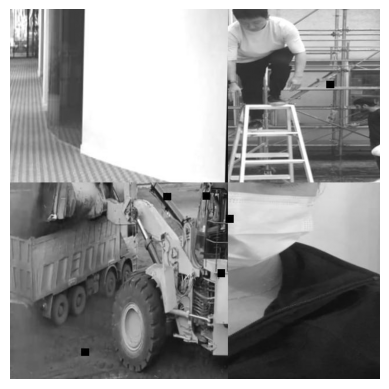

In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

def preprocess_image(image_path):
    try:
        with Image.open(image_path) as img:
            img_array = np.array(img)
            normalized_image_array = img_array / 255.0  # Normalize to [0,1]
            return normalized_image_array, img_array
    except Exception as e:
        print(f"Error processing image at {image_path}: {e}")
        return None, None

def save_normalized_image(normalized_array, original_image_path, save_dir):
    save_path = os.path.join(save_dir, os.path.basename(original_image_path))
    normalized_img = Image.fromarray((normalized_array * 255).astype(np.uint8))  # Convert back to uint8
    normalized_img.save(save_path)
    print(f"Saved normalized image to {save_path}")

def display_image(normalized_array):
    plt.imshow(normalized_array)
    plt.axis('off')
    plt.show()

# Directory paths
train_image_path = TRAIN_IMAGE_PATH
test_image_path = TEST_IMAGE_PATH
valid_image_path = VALID_IMAGE_PATH

# Save directories
normalized_train_dir = os.path.join(drive_base_path, 'data', 'normalized_images', 'train')
normalized_test_dir = os.path.join(drive_base_path, 'data', 'normalized_images', 'test')
normalized_valid_dir = os.path.join(drive_base_path, 'data', 'normalized_images', 'valid')

os.makedirs(normalized_train_dir, exist_ok=True)
os.makedirs(normalized_test_dir, exist_ok=True)
os.makedirs(normalized_valid_dir, exist_ok=True)

# Process and save images of train
if os.access(train_image_path, os.R_OK):
    for filename in os.listdir(train_image_path):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            image_path = os.path.join(train_image_path, filename)
            print(f"Processing image: {image_path}")
            normalized_array, _ = preprocess_image(image_path)
            if normalized_array is not None:
                save_normalized_image(normalized_array, image_path, normalized_train_dir)
else:
    print(f"Cannot access {train_image_path} for reading images.")

# Process and save images of test
if os.access(test_image_path, os.R_OK):
    for filename in os.listdir(test_image_path):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            image_path = os.path.join(test_image_path, filename)
            print(f"Processing image: {image_path}")
            normalized_array, _ = preprocess_image(image_path)
            if normalized_array is not None:
                save_normalized_image(normalized_array, image_path, normalized_test_dir)
else:
    print(f"Cannot access {test_image_path} for reading images.")

# Process and save images of valid
if os.access(valid_image_path, os.R_OK):
    for filename in os.listdir(valid_image_path):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            image_path = os.path.join(valid_image_path, filename)
            print(f"Processing image: {image_path}")
            normalized_array, _ = preprocess_image(image_path)
            if normalized_array is not None:
                save_normalized_image(normalized_array, image_path, normalized_valid_dir)
else:
    print(f"Cannot access {valid_image_path} for reading images.")

# Display one normalized image for verification
sample_image_path = os.path.join(normalized_train_dir, os.listdir(normalized_train_dir)[0])
normalized_array, _ = preprocess_image(sample_image_path)
if normalized_array is not None:
    print(f"Displaying normalized image: {sample_image_path}")
    display_image(normalized_array)

### Checking for Image Properties

In [ ]:
def get_image_properties(image_path):
    # Read the image file
    img = cv2.imread(image_path)

    # Check if the image file is read successfully
    if img is None:
        raise ValueError("Could not read image file")

    # Get image properties
    properties = {
        "width": img.shape[1],
        "height": img.shape[0],
        "channels": img.shape[2] if len(img.shape) == 3 else 1,
        "dtype": img.dtype,
    }

    return properties

In [ ]:
example_file_path = '/content/drive/MyDrive/Capstone/data/images/test/image_53_jpg.rf.3446e366b5d4d905a32e1aedc8fe87de.jpg'

image_properties = get_image_properties(example_file_path)
image_properties

{'width': 640, 'height': 640, 'channels': 3, 'dtype': dtype('uint8')}

Checking model

In [ ]:
CFG.BASE_MODEL_WEIGHTS

'yolov9e.pt'

### YOLO model baseline inference

In [ ]:
model = YOLO(CFG.BASE_MODEL_WEIGHTS)
device_str = CFG.DEVICE if CFG.DEVICE == 'cpu' else 'cuda:0'

results = model.predict(
    source = example_file_path,

    classes = [0],
    conf = 0.30,
    device = device_str,
    imgsz = (image_properties['height'], image_properties['width']),

    save = True,
    save_txt = True,
    save_conf = True,
    exist_ok = True,
)


image 1/1 /content/drive/MyDrive/Capstone/data/images/test/image_53_jpg.rf.3446e366b5d4d905a32e1aedc8fe87de.jpg: 640x640 1 person, 28.0ms
Speed: 1.8ms preprocess, 28.0ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict
3 labels saved to runs/detect/predict/labels


In [ ]:
def resize_image(image_path, img_size):
    img = Image.open(image_path)
    img = img.resize((img_size, img_size))
    return img

def display_image(image_path, img_size=640, print_info=True, hide_axis=False):
    img = resize_image(image_path, img_size)
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    if print_info:
        print('Type: ', type(img))
        print('Shape: ', np.array(img).shape)
    if hide_axis:
        plt.axis('off')
    plt.show()

Type:  <class 'PIL.Image.Image'>
Shape:  (640, 640, 3)


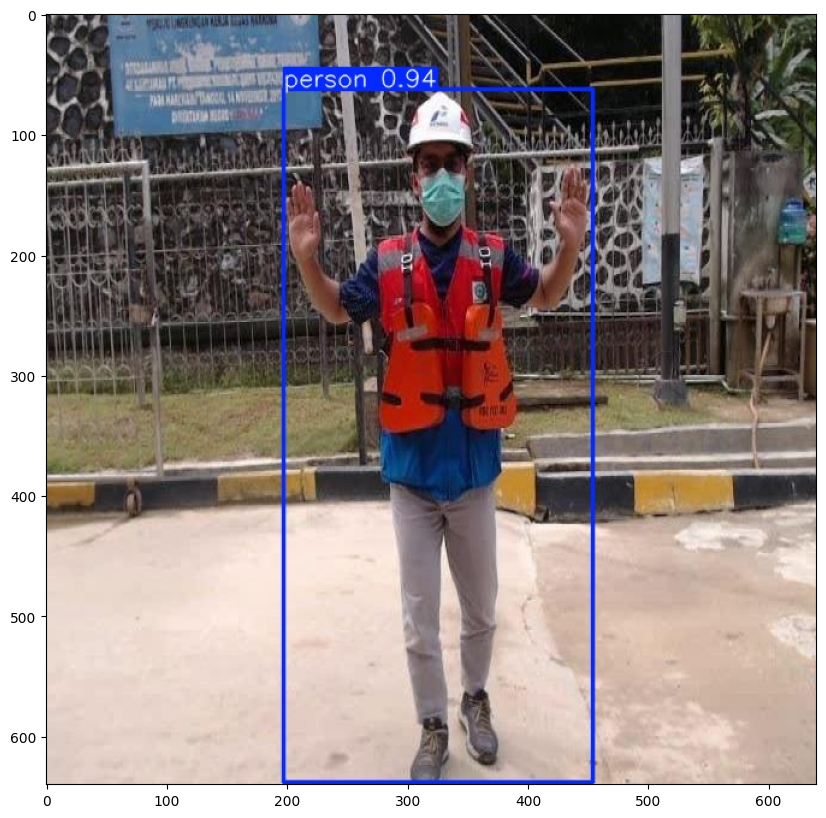

In [ ]:
example_image_inference_output = example_file_path.split('/')[-1]
display_image(f'/content/runs/detect/predict/{example_image_inference_output}')

In [ ]:
print('Model: ', CFG.BASE_MODEL_WEIGHTS)
print('Epochs: ', CFG.EPOCHS)
print('Batch: ', CFG.BATCH_SIZE)

Model:  yolov9e.pt
Epochs:  70
Batch:  16


### Assigning yaml and creating fine tuned YOLO model

In [ ]:
yaml_path = create_yaml_file()

In [ ]:
def train_model(yaml_path):
    model = YOLO(CFG.BASE_MODEL_WEIGHTS)

    img_properties = {'width': 640, 'height': 640}

    # Use 'cuda' or 'cuda:0' if you have a single GPU
    device_str = CFG.DEVICE if CFG.DEVICE == 'cpu' else 'cuda:0'

    model.train(
        data=yaml_path,
        task='detect',
        imgsz=(img_properties['height'], img_properties['width']),
        epochs=CFG.EPOCHS,
        batch=CFG.BATCH_SIZE,
        optimizer=CFG.OPTIMIZER,
        lr0=CFG.LR,
        lrf=CFG.LR_FACTOR,
        weight_decay=CFG.WEIGHT_DECAY,
        dropout=CFG.DROPOUT,
        fraction=CFG.FRACTION,
        patience=CFG.PATIENCE,
        profile=CFG.PROFILE,
        label_smoothing=CFG.LABEL_SMOOTHING,
        name=f'{CFG.BASE_MODEL}_{CFG.EXP_NAME}',
        seed=CFG.SEED,
        val=True,
        amp=True,
        exist_ok=True,
        resume=False,
        device=device_str,  # Changed to use single GPU or CPU
        verbose=False,
    )

    return model

In [ ]:
model = train_model(yaml_path)

Ultralytics YOLOv8.2.72 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
engine/trainer: task=detect, mode=train, model=yolov9e.pt, data=/content/drive/MyDrive/Capstone/model/data.yaml, epochs=70, time=None, patience=20, batch=16, imgsz=(640, 640), save=True, save_period=-1, cache=False, device=cuda:0, workers=8, project=None, name=yolov9e_ppe_css_70_epochs, exist_ok=True, pretrained=True, optimizer=auto, verbose=False, seed=88, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=

100%|██████████| 755k/755k [00:00<00:00, 14.1MB/s]


WARNING ⚠️ YOLOv9 `Silence` module is deprecated in favor of nn.Identity. Please delete local *.pt file and re-download the latest model checkpoint.
Overriding model.yaml nc=80 with nc=10

                   from  n    params  module                                       arguments                     
  0                  -1  1         0  torch.nn.modules.linear.Identity             []                            
  1                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  2                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  3                  -1  1    252160  ultralytics.nn.modules.block.RepNCSPELAN4    [128, 256, 128, 64, 2]        
  4                  -1  1    164352  ultralytics.nn.modules.block.ADown           [256, 256]                    
  5                  -1  1   1004032  ultralytics.nn.modules.block.RepNCSPELAN4    [256, 512, 256, 128, 2]       
  6          

100%|██████████| 6.25M/6.25M [00:00<00:00, 73.4MB/s]


AMP: checks passed ✅
WARNING ⚠️ updating to 'imgsz=640'. 'train' and 'val' imgsz must be an integer, while 'predict' and 'export' imgsz may be a [h, w] list or an integer, i.e. 'yolo export imgsz=640,480' or 'yolo export imgsz=640'


train: Scanning /content/drive/MyDrive/Capstone/data/labels/train.cache... 2605 images, 6 backgrounds, 0 corrupt: 100%|██████████| 2605/2605 [00:00<?, ?it/s]

train: WARNING ⚠️ /content/drive/MyDrive/Capstone/data/images/train/004720_jpg.rf.afc486560a4004c7cfd67910af31a29c.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/Capstone/data/images/train/construction-813-_jpg.rf.b085952261fd98f2e76b8065de149b5f.jpg: 1 duplicate labels removed


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/drive/MyDrive/Capstone/data/labels/valid.cache... 114 images, 10 backgrounds, 0 corrupt: 100%|██████████| 114/114 [00:00<?, ?it/s]


Plotting labels to runs/detect/yolov9e_ppe_css_70_epochs/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 298 weight(decay=0.0), 310 weight(decay=0.0005), 309 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/yolov9e_ppe_css_70_epochs
Starting training for 70 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/70      21.7G      1.245      1.765      1.487        244        640: 100%|██████████| 163/163 [01:22<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.51it/s]

                   all        114        697      0.488      0.513      0.446      0.206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/70      21.5G      1.268      1.573        1.5        328        640: 100%|██████████| 163/163 [01:08<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.06it/s]

                   all        114        697      0.599      0.411      0.435      0.202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/70      21.5G      1.278      1.557      1.506        223        640: 100%|██████████| 163/163 [01:06<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.23it/s]


                   all        114        697       0.59      0.423      0.459      0.205

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/70      21.5G      1.233      1.474      1.469        402        640: 100%|██████████| 163/163 [01:06<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.31it/s]


                   all        114        697      0.625      0.516      0.542      0.233

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/70      21.5G      1.196      1.365      1.435        288        640: 100%|██████████| 163/163 [01:06<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.34it/s]

                   all        114        697      0.772      0.515      0.586      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/70      21.5G      1.159      1.285      1.405        253        640: 100%|██████████| 163/163 [01:06<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.19it/s]


                   all        114        697      0.711      0.575      0.617      0.286

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/70      21.5G      1.117      1.206      1.381        202        640: 100%|██████████| 163/163 [01:06<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.36it/s]

                   all        114        697      0.744      0.612      0.652      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/70      21.7G      1.107       1.15       1.36        284        640: 100%|██████████| 163/163 [01:06<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.32it/s]


                   all        114        697      0.763      0.622      0.666      0.334

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/70      21.5G      1.062      1.102      1.338        319        640: 100%|██████████| 163/163 [01:06<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.37it/s]

                   all        114        697      0.856      0.622      0.706      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/70      21.5G       1.06      1.063      1.334        206        640: 100%|██████████| 163/163 [01:06<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.38it/s]


                   all        114        697      0.778      0.623      0.688      0.384

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/70      21.5G      1.045      1.023      1.314        319        640: 100%|██████████| 163/163 [01:05<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.43it/s]


                   all        114        697      0.843      0.603      0.691      0.363

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/70      20.3G      1.026     0.9736      1.298        317        640: 100%|██████████| 163/163 [01:06<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.43it/s]


                   all        114        697      0.791      0.648      0.712      0.363

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/70      20.5G      0.993     0.9337      1.279        240        640: 100%|██████████| 163/163 [01:06<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.32it/s]


                   all        114        697      0.784       0.67      0.723      0.382

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/70      21.5G      0.976     0.8955      1.265        274        640: 100%|██████████| 163/163 [01:06<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.41it/s]


                   all        114        697        0.8      0.661       0.72      0.406

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/70      21.5G     0.9645     0.8735      1.254        243        640: 100%|██████████| 163/163 [01:05<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.42it/s]


                   all        114        697      0.811      0.706      0.753      0.399

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/70      21.5G     0.9591     0.8542      1.251        190        640: 100%|██████████| 163/163 [01:06<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.40it/s]


                   all        114        697      0.846      0.691      0.753       0.42

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/70      21.5G      0.943     0.8451      1.246        221        640: 100%|██████████| 163/163 [01:06<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.44it/s]


                   all        114        697      0.853      0.669      0.753      0.426

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/70      21.5G     0.9316     0.8278       1.24        340        640: 100%|██████████| 163/163 [01:06<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.42it/s]


                   all        114        697      0.858      0.675      0.765      0.412

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/70      21.5G      0.906     0.7954       1.22        282        640: 100%|██████████| 163/163 [01:05<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.36it/s]


                   all        114        697       0.84      0.675       0.75      0.431

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/70      21.5G     0.9029     0.7842      1.212        228        640: 100%|██████████| 163/163 [01:06<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.40it/s]


                   all        114        697      0.867      0.665      0.747      0.429

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/70      20.5G     0.8846     0.7504      1.197        275        640: 100%|██████████| 163/163 [01:06<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.39it/s]

                   all        114        697      0.861      0.698      0.775      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/70      21.5G     0.8775     0.7367      1.194        216        640: 100%|██████████| 163/163 [01:06<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.42it/s]


                   all        114        697      0.851       0.72      0.784      0.458

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/70      21.5G     0.8596     0.7202      1.186        386        640: 100%|██████████| 163/163 [01:05<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.41it/s]


                   all        114        697       0.89      0.697       0.78      0.478

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/70      20.5G     0.8529     0.7114      1.179        306        640: 100%|██████████| 163/163 [01:06<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.40it/s]


                   all        114        697      0.842      0.696      0.772      0.477

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/70      21.5G     0.8378     0.6904      1.169        275        640: 100%|██████████| 163/163 [01:06<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.41it/s]


                   all        114        697      0.888      0.695      0.794      0.476

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/70      21.5G     0.8302     0.6823       1.16        226        640: 100%|██████████| 163/163 [01:06<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.39it/s]


                   all        114        697      0.851      0.724      0.794      0.487

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/70      21.5G     0.8156      0.664      1.149        264        640: 100%|██████████| 163/163 [01:06<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.45it/s]


                   all        114        697      0.823      0.761      0.805      0.503

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/70      21.5G     0.8075     0.6476      1.142        352        640: 100%|██████████| 163/163 [01:06<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.44it/s]


                   all        114        697      0.869      0.716      0.809      0.493

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/70      21.5G     0.7971     0.6421      1.147        234        640: 100%|██████████| 163/163 [01:06<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.40it/s]


                   all        114        697       0.86      0.731      0.804      0.484

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/70      21.5G     0.7915     0.6324      1.134        396        640: 100%|██████████| 163/163 [01:06<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.46it/s]


                   all        114        697      0.873       0.74      0.815      0.532

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/70      21.5G     0.7752     0.6245      1.131        177        640: 100%|██████████| 163/163 [01:06<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.41it/s]


                   all        114        697      0.863      0.734        0.8      0.511

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/70      21.5G     0.7737     0.6128      1.125        199        640: 100%|██████████| 163/163 [01:06<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.46it/s]


                   all        114        697      0.902      0.742      0.823      0.536

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/70      21.5G     0.7651     0.5984      1.111        303        640: 100%|██████████| 163/163 [01:06<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.42it/s]


                   all        114        697      0.899      0.748      0.821       0.53

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/70      21.5G     0.7544     0.5862      1.118        189        640: 100%|██████████| 163/163 [01:06<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.42it/s]


                   all        114        697      0.899      0.737      0.825      0.527

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/70      21.5G     0.7429     0.5754      1.112        281        640: 100%|██████████| 163/163 [01:06<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.45it/s]


                   all        114        697      0.888      0.752      0.821      0.527

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/70      21.5G      0.738     0.5653      1.099        298        640: 100%|██████████| 163/163 [01:06<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.36it/s]


                   all        114        697      0.877      0.772      0.834       0.57

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/70      21.5G     0.7201     0.5483      1.098        225        640: 100%|██████████| 163/163 [01:06<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.45it/s]


                   all        114        697      0.909      0.773      0.838      0.568

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/70      21.5G      0.715     0.5446      1.086        188        640: 100%|██████████| 163/163 [01:06<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.43it/s]


                   all        114        697      0.899      0.748      0.832      0.562

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/70      21.5G     0.7063     0.5414      1.081        283        640: 100%|██████████| 163/163 [01:06<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.41it/s]

                   all        114        697      0.892      0.771       0.84      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/70      21.5G     0.6989      0.523      1.072        327        640: 100%|██████████| 163/163 [01:06<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.39it/s]


                   all        114        697      0.889      0.763      0.846      0.581

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/70      20.5G     0.6976     0.5231      1.079        310        640: 100%|██████████| 163/163 [01:06<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.37it/s]


                   all        114        697      0.936      0.762      0.847      0.571

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/70      21.5G     0.6835     0.5138      1.069        478        640: 100%|██████████| 163/163 [01:06<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.42it/s]


                   all        114        697      0.897       0.79      0.845      0.568

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/70      21.5G      0.683     0.5095      1.062        233        640: 100%|██████████| 163/163 [01:06<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.37it/s]


                   all        114        697      0.908      0.772      0.844      0.571

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/70      21.5G     0.6739     0.5012      1.063        303        640: 100%|██████████| 163/163 [01:06<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.36it/s]

                   all        114        697      0.915       0.79      0.852      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/70      21.5G     0.6641     0.4923      1.058        219        640: 100%|██████████| 163/163 [01:06<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.44it/s]


                   all        114        697      0.917      0.765      0.847      0.582

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/70      22.1G     0.6611     0.4909      1.061        317        640: 100%|██████████| 163/163 [01:06<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.49it/s]


                   all        114        697      0.913      0.795      0.855      0.595

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/70      21.5G     0.6482     0.4836       1.05        357        640: 100%|██████████| 163/163 [01:05<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.39it/s]


                   all        114        697      0.917      0.785      0.855      0.596

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/70      21.5G     0.6441     0.4737      1.044        366        640: 100%|██████████| 163/163 [01:06<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.38it/s]


                   all        114        697      0.922      0.782      0.857      0.599

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/70      21.5G     0.6362      0.465      1.038        312        640: 100%|██████████| 163/163 [01:06<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.24it/s]

                   all        114        697      0.913      0.799      0.861      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/70      21.5G     0.6324     0.4624      1.035        255        640: 100%|██████████| 163/163 [01:06<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.43it/s]


                   all        114        697      0.917      0.788      0.858      0.596

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/70      21.5G     0.6156     0.4502      1.024        264        640: 100%|██████████| 163/163 [01:05<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.46it/s]


                   all        114        697      0.901      0.797      0.858      0.593

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/70      20.5G     0.6105     0.4369      1.023        295        640: 100%|██████████| 163/163 [01:06<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.35it/s]

                   all        114        697      0.918      0.804      0.868      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/70      21.8G     0.6069     0.4438      1.021        346        640: 100%|██████████| 163/163 [01:06<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.39it/s]


                   all        114        697      0.914      0.801      0.866      0.619

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/70      21.5G     0.5973      0.432      1.016        184        640: 100%|██████████| 163/163 [01:06<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.46it/s]


                   all        114        697      0.917      0.784      0.864      0.605

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/70      21.5G      0.596     0.4307      1.013        254        640: 100%|██████████| 163/163 [01:05<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.47it/s]


                   all        114        697      0.935      0.807      0.875      0.613

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/70      20.3G     0.5924     0.4189      1.012        300        640: 100%|██████████| 163/163 [01:06<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.44it/s]


                   all        114        697      0.951      0.798      0.871      0.632

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/70      21.7G     0.5837     0.4217      1.011        283        640: 100%|██████████| 163/163 [01:06<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.36it/s]


                   all        114        697      0.907      0.831       0.88      0.624

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/70      21.5G     0.5741     0.4157      1.005        250        640: 100%|██████████| 163/163 [01:06<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.46it/s]


                   all        114        697      0.953      0.792      0.873      0.623

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/70      21.5G     0.5666     0.4071     0.9964        229        640: 100%|██████████| 163/163 [01:05<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.41it/s]


                   all        114        697      0.954      0.812      0.873      0.635

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/70      20.3G      0.563     0.3998     0.9965        297        640: 100%|██████████| 163/163 [01:06<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.39it/s]


                   all        114        697      0.956      0.797      0.872      0.629
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      61/70      20.3G     0.5605     0.3456     0.9843        184        640: 100%|██████████| 163/163 [01:12<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.37it/s]


                   all        114        697      0.935      0.812      0.879      0.624

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      62/70      21.5G     0.5457     0.3295     0.9764        110        640: 100%|██████████| 163/163 [01:06<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.43it/s]


                   all        114        697      0.961      0.809       0.88      0.627

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      63/70      21.5G     0.5316     0.3201     0.9661        138        640: 100%|██████████| 163/163 [01:05<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.19it/s]


                   all        114        697      0.913      0.836      0.887      0.641

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      64/70      21.5G     0.5189      0.315     0.9615        126        640: 100%|██████████| 163/163 [01:06<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.45it/s]

                   all        114        697      0.971      0.805      0.889      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      65/70      20.3G     0.5126     0.3116     0.9571        123        640: 100%|██████████| 163/163 [01:05<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.43it/s]

                   all        114        697      0.963      0.805      0.887      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      66/70      21.5G     0.5037     0.3045     0.9495        143        640: 100%|██████████| 163/163 [01:05<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.40it/s]

                   all        114        697      0.945      0.824      0.887      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      67/70      21.5G     0.4998     0.3029     0.9488        140        640: 100%|██████████| 163/163 [01:05<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.45it/s]


                   all        114        697       0.93      0.843      0.891      0.642

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      68/70      21.5G     0.4945     0.2986     0.9446        130        640: 100%|██████████| 163/163 [01:06<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.38it/s]


                   all        114        697      0.948      0.832      0.891      0.657

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      69/70      21.5G     0.4823     0.2891     0.9417        173        640: 100%|██████████| 163/163 [01:05<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.44it/s]

                   all        114        697      0.955      0.828       0.89      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      70/70      21.5G     0.4782     0.2905     0.9401        193        640: 100%|██████████| 163/163 [01:05<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.38it/s]

                   all        114        697      0.938      0.843      0.896      0.653



70 epochs completed in 1.373 hours.
Optimizer stripped from runs/detect/yolov9e_ppe_css_70_epochs/weights/last.pt, 117.3MB
Optimizer stripped from runs/detect/yolov9e_ppe_css_70_epochs/weights/best.pt, 117.3MB

Validating runs/detect/yolov9e_ppe_css_70_epochs/weights/best.pt...
Ultralytics YOLOv8.2.72 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
YOLOv9e summary (fused): 687 layers, 57,384,110 parameters, 0 gradients, 189.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.23s/it]


                   all        114        697      0.955      0.828       0.89      0.658
Speed: 0.1ms preprocess, 21.6ms inference, 0.0ms loss, 17.6ms postprocess per image
Results saved to runs/detect/yolov9e_ppe_css_70_epochs


In [ ]:
image_properties

{'width': 640, 'height': 640, 'channels': 3, 'dtype': dtype('uint8')}

### Exporting model for deployment and testing

In [ ]:
def export_model(model):
    # Export the model for deployment
    model.export(
        format='onnx',  # Could be 'openvino', 'engine', 'tflite', etc.
        imgsz=(640, 640),
        half=False,
        int8=False,
        simplify=False,
        nms=False,
    )

In [ ]:
export_model(model)

Ultralytics YOLOv8.2.72 🚀 Python-3.10.12 torch-2.3.1+cu121 CPU (Intel Xeon 2.20GHz)
YOLOv9e summary (fused): 687 layers, 57,384,110 parameters, 0 gradients, 189.2 GFLOPs

PyTorch: starting from 'runs/detect/yolov9e_ppe_css_70_epochs/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 14, 8400) (111.9 MB)
requirements: Ultralytics requirement ['onnx>=1.12.0'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 111.2 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 5.5s, installed 1 package: ['onnx>=1.12.0']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.16.2 opset 17...
ONNX: export success ✅ 14.0s, saved as 'runs/detect/yolov9e_ppe_css_70_epochs/weights/best.onnx' (219.3 MB)

Export complete (18.2s)
Results saved to /content/runs/detect/yolov9e_ppe_css_70_epochs/weights
Predict:         yolo predict task=detect model=runs/detect/yolov9e_ppe_css_70_e

### Checking Model Evaluation

In [ ]:
results_paths = [
    i for i in
    glob.glob(f'/content/runs/detect/yolov9e_ppe_css_70_epochs/*.png') +
    glob.glob(f'/content/runs/detect/yolov9e_ppe_css_70_epochs/*.jpg')
    if 'batch' not in i
]

results_paths

['/content/runs/detect/yolov9e_ppe_css_70_epochs/results.png',
 '/content/runs/detect/yolov9e_ppe_css_70_epochs/confusion_matrix.png',
 '/content/runs/detect/yolov9e_ppe_css_70_epochs/F1_curve.png',
 '/content/runs/detect/yolov9e_ppe_css_70_epochs/P_curve.png',
 '/content/runs/detect/yolov9e_ppe_css_70_epochs/R_curve.png',
 '/content/runs/detect/yolov9e_ppe_css_70_epochs/confusion_matrix_normalized.png',
 '/content/runs/detect/yolov9e_ppe_css_70_epochs/PR_curve.png',
 '/content/runs/detect/yolov9e_ppe_css_70_epochs/labels_correlogram.jpg',
 '/content/runs/detect/yolov9e_ppe_css_70_epochs/labels.jpg']

### Please refer to my report for evaluation of the important results

/content/runs/detect/yolov9e_ppe_css_70_epochs/F1_curve.png


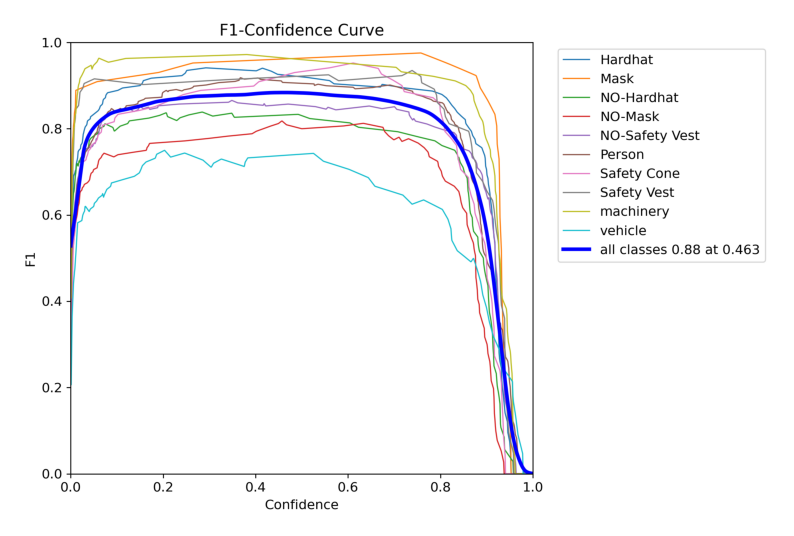



/content/runs/detect/yolov9e_ppe_css_70_epochs/PR_curve.png


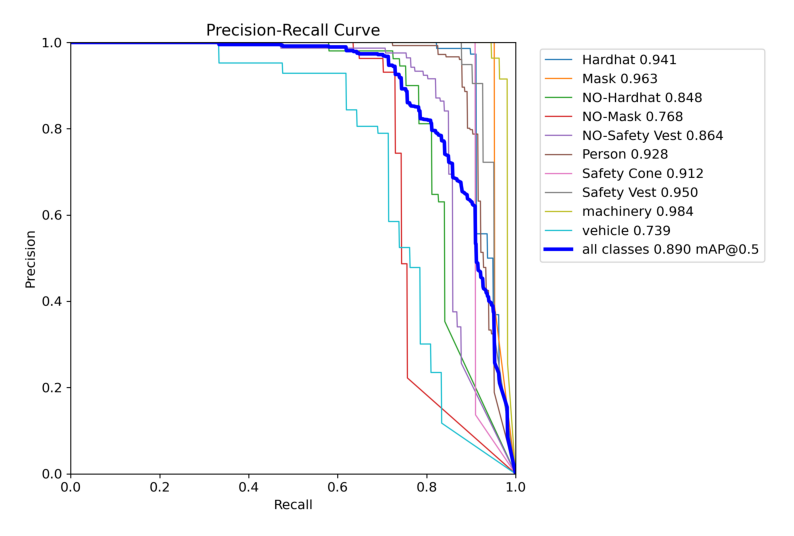



/content/runs/detect/yolov9e_ppe_css_70_epochs/P_curve.png


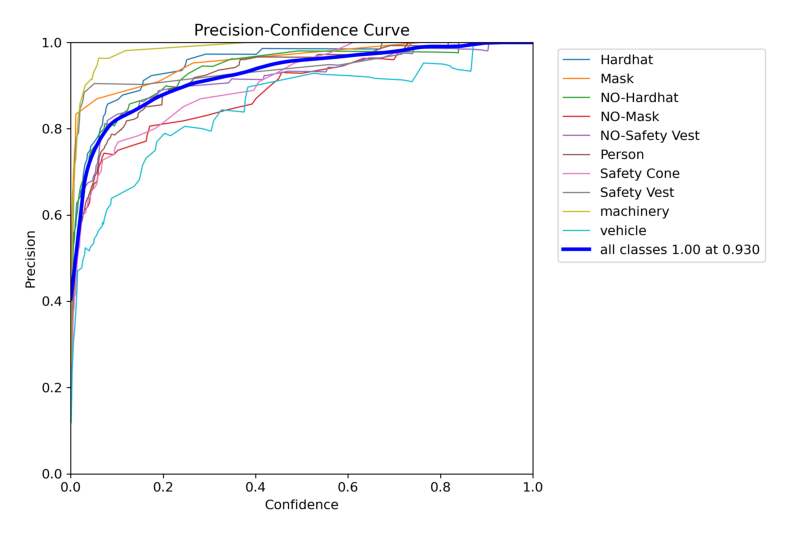



/content/runs/detect/yolov9e_ppe_css_70_epochs/R_curve.png


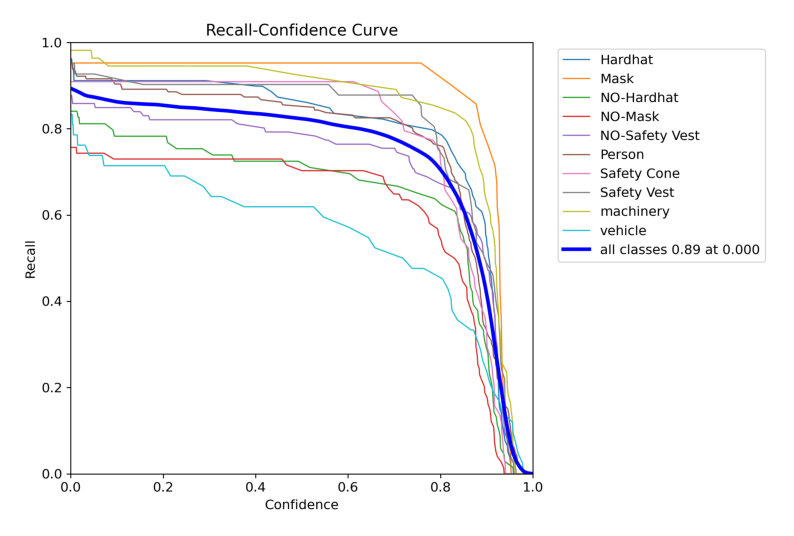



/content/runs/detect/yolov9e_ppe_css_70_epochs/confusion_matrix.png


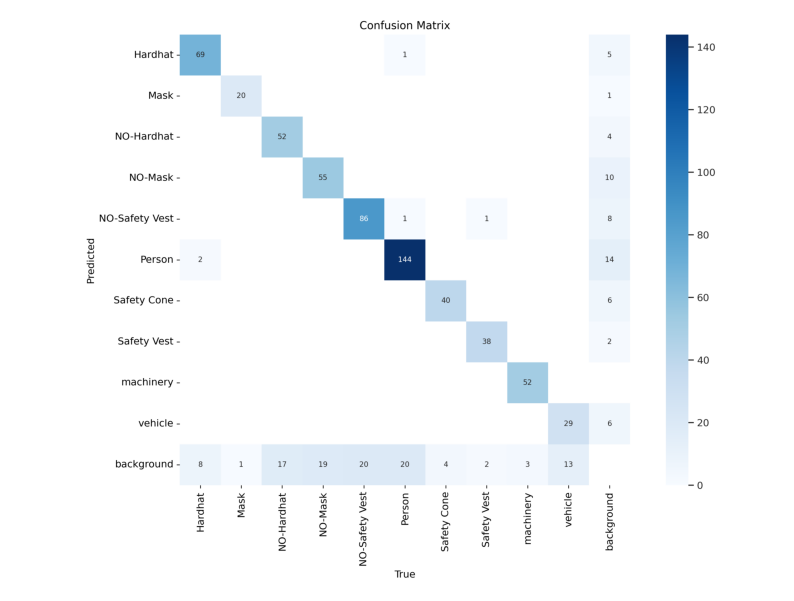



/content/runs/detect/yolov9e_ppe_css_70_epochs/confusion_matrix_normalized.png


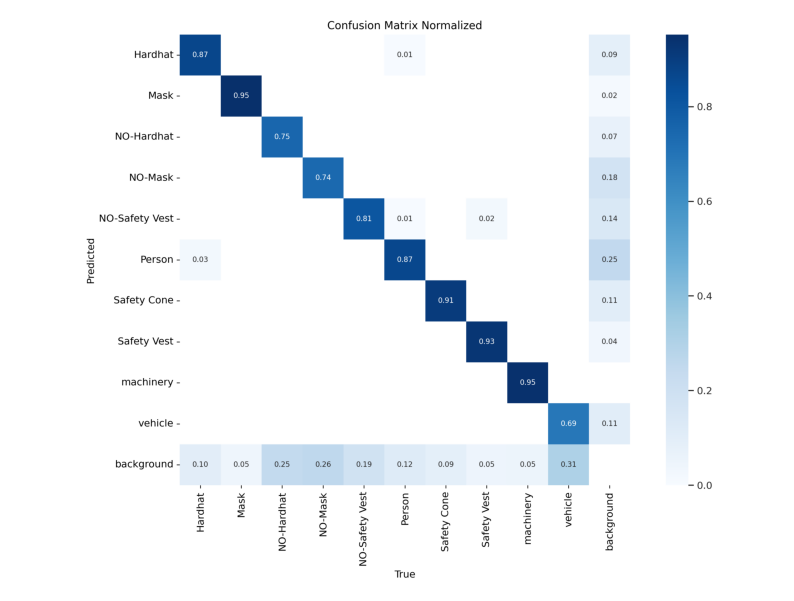



/content/runs/detect/yolov9e_ppe_css_70_epochs/labels.jpg


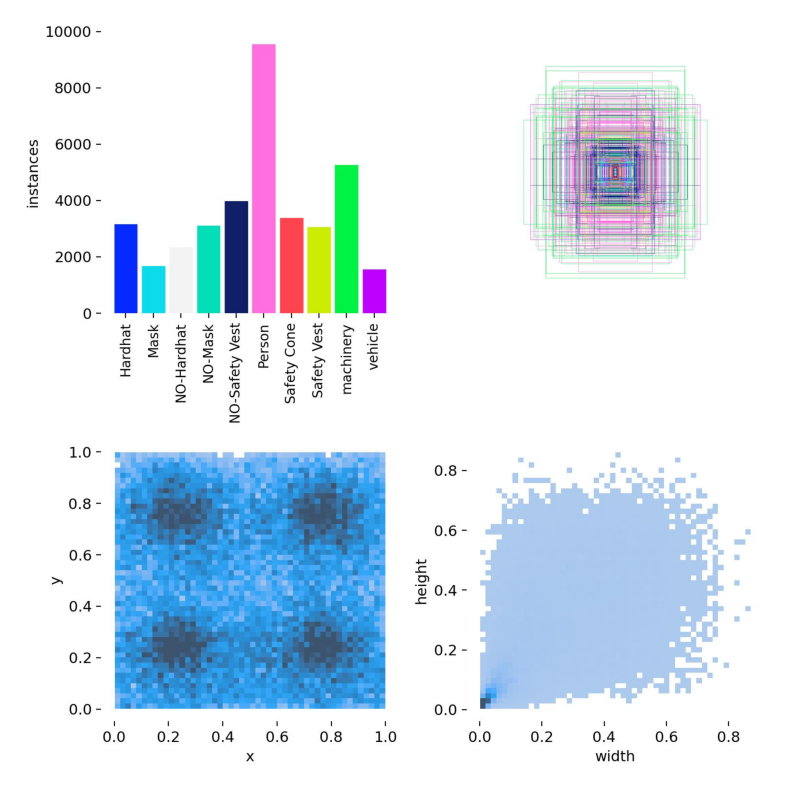



/content/runs/detect/yolov9e_ppe_css_70_epochs/labels_correlogram.jpg


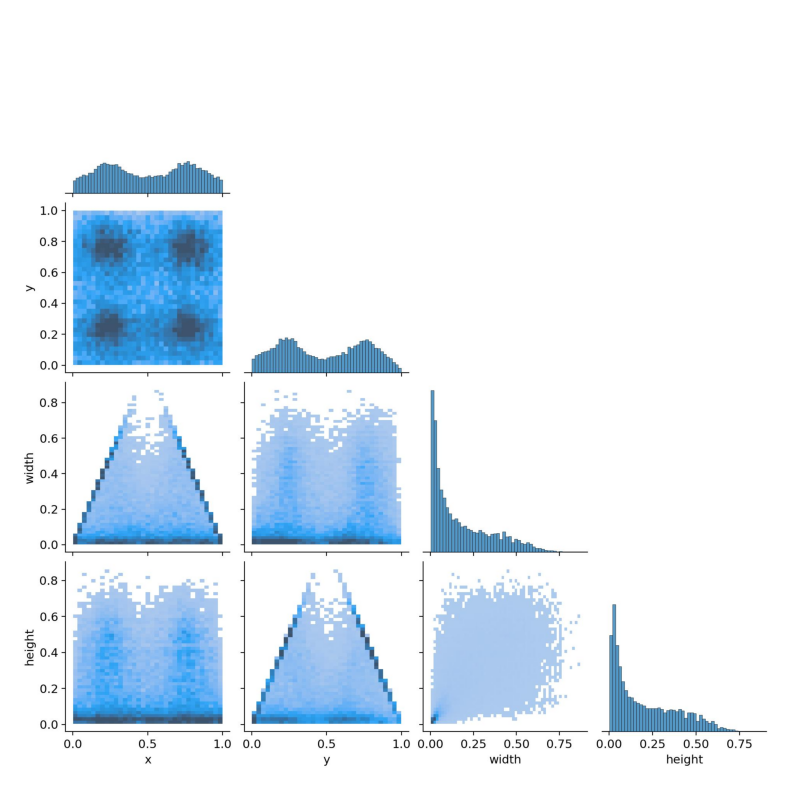



/content/runs/detect/yolov9e_ppe_css_70_epochs/results.png


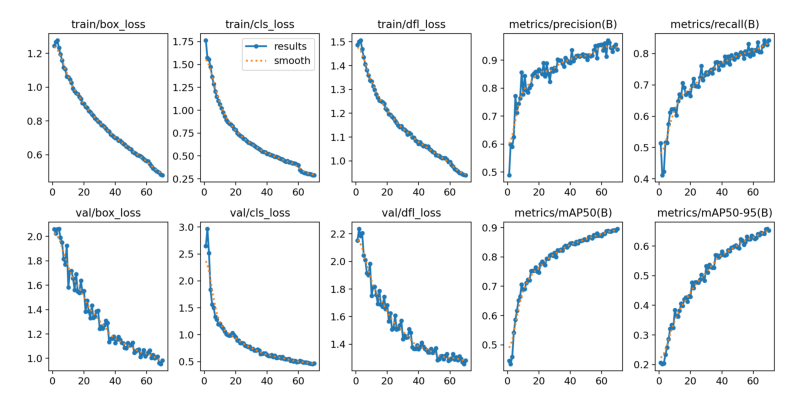

In [ ]:
for file in sorted(results_paths):
    print(file)
    display_image(file, print_info=False, hide_axis=True)
    print('\n')

### Saving numeriacal results to access as csv

In [ ]:
results = pd.read_csv('/content/runs/detect/yolov9e_ppe_css_70_epochs/results.csv')
results.to_csv(f'{OUTPUT_DIR}/results.csv', index=False)

### Plotting training metrics from CSV

In [ ]:
# Function to plot training metrics from CSV
def plot_training_metrics(df):
    metrics = ['box_loss', 'cls_loss', 'dfl_loss']
    titles = ['Box Loss', 'Cls Loss', 'DFL Loss']

    plt.figure(figsize=(15, 10))

    for i, metric in enumerate(metrics):
        plt.subplot(3, 1, i + 1)
        plt.plot(df['epoch'], df[f'train/{metric}'], label=f'Training {metric}')
        plt.plot(df['epoch'], df[f'val/{metric}'], label=f'Validation {metric}')
        plt.title(titles[i])
        plt.xlabel('Epoch')
        plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
def print_best_performance(df):
    print('*' * 50)
    print('\nBest Training Box loss: ', df['train/box_loss'].min(), ', on epoch: ', df['train/box_loss'].idxmin() + 1, '\n')
    print('Best Validation Box loss: ', df['val/box_loss'].min(), ', on epoch: ', df['val/box_loss'].idxmin() + 1, '\n')

    print('=' * 50)
    print('\nBest Training Cls loss: ', df['train/cls_loss'].min(), ', on epoch: ', df['train/cls_loss'].idxmin() + 1, '\n')
    print('Best Validation Cls loss: ', df['val/cls_loss'].min(), ', on epoch: ', df['val/cls_loss'].idxmin() + 1, '\n')

    print('=' * 50)
    print('\nBest Training DFL loss: ', df['train/dfl_loss'].min(), ', on epoch: ', df['train/dfl_loss'].idxmin() + 1, '\n')
    print('Best Validation DFL loss: ', df['val/dfl_loss'].min(), ', on epoch: ', df['val/dfl_loss'].idxmin() + 1, '\n')

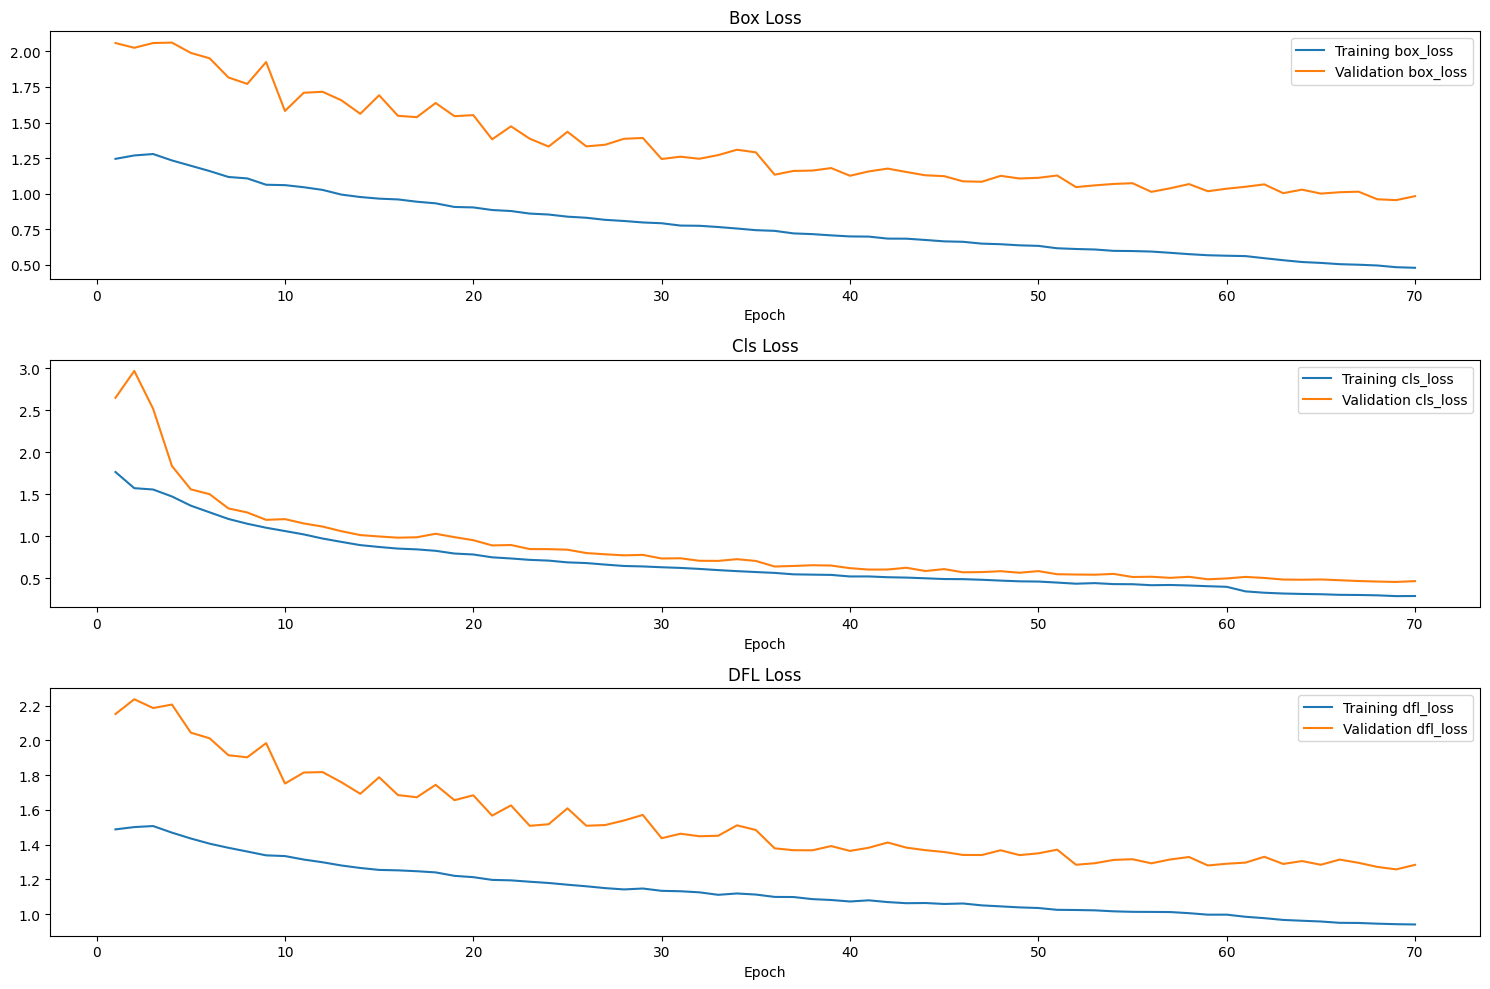

**************************************************

Best Training Box loss:  0.47821 , on epoch:  70 

Best Validation Box loss:  0.95419 , on epoch:  69 


Best Training Cls loss:  0.28911 , on epoch:  69 

Best Validation Cls loss:  0.45786 , on epoch:  69 


Best Training DFL loss:  0.94007 , on epoch:  70 

Best Validation DFL loss:  1.2571 , on epoch:  69 



In [ ]:
df = pd.read_csv(r'/content/runs/detect/yolov9e_ppe_css_70_epochs/results.csv')
df = df.rename(columns=lambda x: x.replace(" ", ""))
df.to_csv(f'{OUTPUT_DIR}/training_log_df.csv', index=False)
plot_training_metrics(df)
print_best_performance(df)

### Testing model on all testing images

In [ ]:
def perform_inference_and_visualize_all(model):
    # List all image files in the test directory
    test_image_files = [f for f in os.listdir(TEST_IMAGE_PATH) if f.endswith(('.jpg', '.png', '.jpeg'))]

    # Iterate over each test image
    for image_file in test_image_files:
        test_image_path = os.path.join(TEST_IMAGE_PATH, image_file)

        # Perform inference on the test image
        results = model.predict(test_image_path, conf=0.25, device=CFG.DEVICE)

        # Display the result
        result_image = results[0].plot()
        plt.figure(figsize=(12, 12))
        plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title(f'Test Image Prediction: {image_file}')
        plt.show()

In [ ]:
perform_inference_and_visualize_all(model)

### Saving the model to drive to download

In [ ]:
import shutil

# Source directory path in Colab
source_dir = '/content/runs/detect'  # Replace with your actual directory path

# Destination directory in Google Drive
destination_dir = '/content/drive/MyDrive/Capstone/yolov9e_ppe_css_70_epochs'  # Replace with the desired path in Google Drive

# Copy the directory to Google Drive
shutil.copytree(source_dir, destination_dir)
print("Directory saved to Google Drive.")

Directory saved to Google Drive.


### Applying the model to test on video using 'Bytetrack'

In [3]:
import os
from google.colab import drive
from IPython.display import HTML
from base64 import b64encode
from ultralytics import YOLO

# Mount Google Drive
drive.mount('/content/drive')

# Define paths
drive_base_path = '/content/drive/MyDrive/Capstone'
weights_dir = os.path.join(drive_base_path, 'yolov9e_ppe_css_70_epochs', 'yolov9e_ppe_css_70_epochs', 'weights')
video_path = os.path.join(drive_base_path, 'JapanPPE.mp4')  # Update this path to the actual video location
save_dir = os.path.join(drive_base_path, 'tracking_results2')

# Load the trained detection model
model = YOLO(os.path.join(weights_dir, 'best.pt'))

# Run tracking
tracking_results = model.track(
    source=video_path,
    show=True,
    save=True,
    name=save_dir,
    imgsz=640,
    tracker="bytetrack.yaml"  # Using ByteTrack
)

Convert output video from .avi to .mp4
!ffmpeg -i /content/drive/MyDrive/Capstone/tracking_results/construction_workers.avi /content/drive/MyDrive/Capstone/tracking_results/construction_workersg.mp4


Mounted at /content/drive
ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvor

In [ ]:
def play_video(filename):
    video_data = open(filename, 'rb').read()
    video_src = 'data:video/mp4;base64,' + b64encode(video_data).decode()

    html = f'<video width=1000 controls autoplay loop><source src="{video_src}" type="video/mp4"></video>'
    return HTML(html)

# Display the converted video
play_video('/content/drive/MyDrive/Capstone/tracking_results/construction_workersg.mp4')
